In [557]:
import time
import cv2
import numpy as np
import sys
import getopt
import operator
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import skimage
from skimage import feature
import scipy
from scipy import ndimage

In [94]:
def read_image(IMG_NAME):
    img = mpimg.imread(IMG_NAME)
    return img

In [526]:
def show_all_circles(image, cx, cy, rad, color='r'):
    """
    image: numpy array, representing the grayscsale image
    cx, cy: numpy arrays or lists, centers of the detected blobs
    rad: numpy array or list, radius of the detected blobs
    """
    import matplotlib.pyplot as plt
    from matplotlib.patches import Circle

    fig, ax = plt.subplots(figsize=[10,10])
    ax.axis('off')
    ax.set_aspect('equal')
    ax.imshow(image, cmap='gray')
    for x, y, r in zip(cx, cy, rad):
        circ = Circle((x, y), r, color=color, fill=False)
        ax.add_patch(circ)

    plt.title('%i circles' % len(cx))
    plt.show()

--- 0.1785578727722168 seconds ---


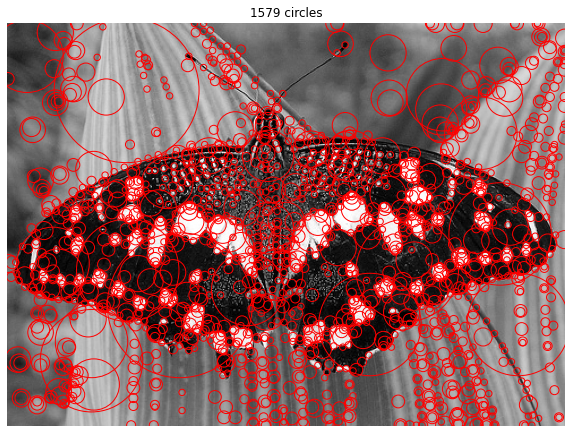

In [624]:
###Part2
#reading and convering to gray scale
input_image = read_image('hw3_images/butterfly.jpg')
img = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)/255

#parameters
n = 10  #number of levels
k = 2**0.5    #increase factor
sigma = 2     #initial sigma
threshold = 0.015    #threshod of laplacian of gaussian

#initializing
cx = []
cy = []
rad = []

h = img.shape[0]
w = img.shape[1]
scale_space = np.empty((h,w,n+2))
scale_space[:,:,0]=0
scale_space[:,:,-1]=0

start_time = time.time()

#creating scale space
for i in np.arange(1,n+1):
    
    scale_image = cv2.resize(img, (int(w/(k**(i-1))) , int(h/(k**(i-1)))))
    
    R = (scipy.ndimage.filters.gaussian_laplace(scale_image,sigma))**2
    
    scale_space[:,:,i] = cv2.resize(R, (w , h))
    
#creating footprint mask to suppress local non maximums (odd sized)
m = int(np.ceil(2*sigma*(2**0.5)))
if (m%2) == 0:
    m += 1
    
footprint = np.ones([m,m])
footprint[math.floor(m/2),math.floor(m/2)] = 0

#slicing for 2D supression
for i in np.arange(1,n+1):
    filt = scipy.ndimage.filters.rank_filter(scale_space[:,:,i], rank=-1, footprint=footprint, mode='constant', cval=0.0)
    scale_space[:,:,i] = scale_space[:,:,i] * (scale_space[:,:,i]>filt)

print("--- %s seconds ---" % (time.time() - start_time))     
    
#thresholding
scale_space[scale_space<(threshold*np.max(scale_space))] = 0
    
#3D non maxima oppression and finding blob positions
for i in np.arange(1,n+1):
    
    #3D mask
    m = int(np.ceil(2*sigma*(k**(i-1))*(2**0.5)))
    if (m%2) == 0:
        m += 1
    footprint = np.ones([m,m,3])
    footprint[math.floor(m/2),math.floor(m/2),1] = 0
    
    part3D = scale_space[:,:,i-1:i+1]
    filt_3d = scipy.ndimage.filters.rank_filter(part3D, rank=-1, footprint=footprint, mode='constant', cval=0.0)
    part3D = part3D * (part3D>filt_3d)
    y, x = np.where (part3D[:,:,1] != 0)
    r = np.ones((len(x)))*sigma*(k**(i-1))*(2**0.5)
    
    cx = np.hstack((cx,x))
    cy = np.hstack((cy,y))
    rad = np.hstack((rad,r))

    
show_all_circles(img, cx, cy, rad, color='r')

--- 11.022745609283447 seconds ---


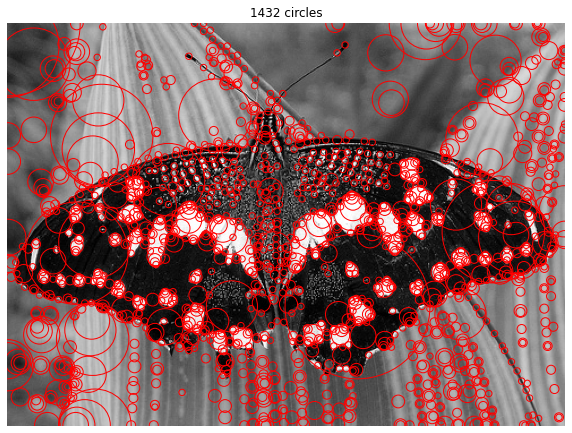

In [625]:
#reading and convering to gray scale
input_image = read_image('hw3_images/butterfly.jpg')
img = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)/255

#parameters
n = 10
k = 2**0.5
sigma = 2
threshold = 0.015

#initializing
cx = []
cy = []
rad = []

h = img.shape[0]
w = img.shape[1]
scale_space = np.empty((h,w,n+2))
scale_space[:,:,0]=0
scale_space[:,:,-1]=0

start_time = time.time()

#creating scale space and 2D masked slices at the same time
for i in np.arange(1,n+1):
    
    R = (((sigma*(k**i))**2)*scipy.ndimage.filters.gaussian_laplace(img,sigma*(k**(i-1))))**2
    
    m = int(np.ceil(2*sigma*(k**(i-1))*(2**0.5)))
    if (m%2) == 0:
        m += 1
    footprint = np.ones([m,m])
    footprint[math.floor(m/2),math.floor(m/2)] = 0
    filt_R = scipy.ndimage.filters.rank_filter(R, rank=-1, footprint=footprint, mode='constant', cval=0.0)
    scale_space[:,:,i] = R * (R>filt_R)
    
print("--- %s seconds ---" % (time.time() - start_time))    
    
scale_space[scale_space<(threshold*np.max(scale_space))] = 0
    
#performing 3D suppression and finding blob positions
for i in np.arange(1,n+1):
    
    m = int(np.ceil(2*sigma*(k**(i-1))*(2**0.5)))
    if (m%2) == 0:
        m += 1
    footprint = np.ones([m,m,3])
    footprint[math.floor(m/2),math.floor(m/2),1] = 0
    
    part3D = scale_space[:,:,i-1:i+1]
    filt_3d = scipy.ndimage.filters.rank_filter(part3D, rank=-1, footprint=footprint, mode='constant', cval=0.0)
    part3D = part3D * (part3D>filt_3d)
    y, x = np.where (part3D[:,:,1] != 0)
    r = np.ones((len(x)))*sigma*(k**(i-1))*(2**0.5)
    
    cx = np.hstack((cx,x))
    cy = np.hstack((cy,y))
    rad = np.hstack((rad,r))

    
show_all_circles(img, cx, cy, rad, color='r')